<a href="https://colab.research.google.com/github/sombr3ro/Machine-Learning-Repo/blob/main/Semi_Supervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import torch 
from torchvision.datasets import STL10
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
from torchvision.models import vgg16
from torch.optim import SGD,Adam
from torch.nn import CrossEntropyLoss
import random

In [ ]:
img_transforms = transforms.Compose([
                         transforms.ColorJitter(0.2,0.2,0.2,0.2),
                         transforms.RandomAffine(10),
                         transforms.ToTensor(),
                         transforms.Normalize(mean= [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225])
])

In [ ]:
train_dat = STL10('train','train',transform=img_transforms,download=False)
test_dat = STL10('test','test',transform= img_transforms, download=False)
unlabelled_dat = STL10('unlabel','unlabeled',transform=img_transforms, download=False)

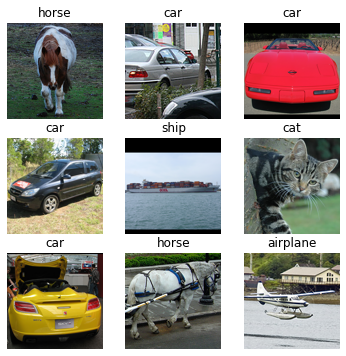

In [ ]:
nrows = 3
ncols = 3
fig,axs = plt.subplots(nrows,ncols, figsize=(6,6))
for i in range(nrows):
  for j in range(ncols):
    ax = axs[i][j]
    idx = np.random.randint(len(test_dat))
    img = test_dat.data[idx].transpose(1,2,0)
    label = test_dat.classes[test_dat.labels[idx]]
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
model = vgg16(pretrained=False)
model.classifier[3] = torch.nn.Linear(4096,1024)
model.classifier[6] = torch.nn.Linear(1024,10)
model = model.to(device)
summary(model,(3,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 96, 96]           1,792
              ReLU-2           [-1, 64, 96, 96]               0
            Conv2d-3           [-1, 64, 96, 96]          36,928
              ReLU-4           [-1, 64, 96, 96]               0
         MaxPool2d-5           [-1, 64, 48, 48]               0
            Conv2d-6          [-1, 128, 48, 48]          73,856
              ReLU-7          [-1, 128, 48, 48]               0
            Conv2d-8          [-1, 128, 48, 48]         147,584
              ReLU-9          [-1, 128, 48, 48]               0
        MaxPool2d-10          [-1, 128, 24, 24]               0
           Conv2d-11          [-1, 256, 24, 24]         295,168
             ReLU-12          [-1, 256, 24, 24]               0
           Conv2d-13          [-1, 256, 24, 24]         590,080
             ReLU-14          [-1, 256,

In [ ]:
optim = SGD(model.parameters(), lr = 1e-2, weight_decay=1e-4, momentum=0.9)
loss_fn = CrossEntropyLoss()

In [ ]:
from torch.utils.data import RandomSampler,BatchSampler

In [ ]:
def test(test_dl,model, loss_fn):
  total_loss = 0.0
  total_acc = 0.0
  x_size = 0

  model.eval()
  for x,y in test_dl:
    x = x.to(device)
    y = y.to(device)
    with torch.no_grad():
      pred = model(x)
      loss = loss_fn(pred, y)

      loss_val = loss.item()
      accuracy = (pred.argmax(axis=1)==y).sum().item()
      x_size+= x.shape[0]

      total_loss+= loss_val
      total_acc+= accuracy

  
  total_acc = total_acc/x_size*100.0
  total_loss = total_loss/x_size
  return total_loss, total_acc

In [ ]:
def train(train_dl,model, loss_fn, optim):
  total_loss = 0.0
  total_acc = 0.0
  x_size=0.0
  for i,(x,y) in enumerate(train_dl):
    x = x.type(torch.float).to(device)
    y = y.type(torch.long).to(device)
    pred = model(x)
    loss = loss_fn(pred, y)

    loss_val = loss.item()
    accuracy = (pred.argmax(axis=1)==y).sum().item()
    x_size+= x.shape[0]

    total_loss+= loss_val
    total_acc+= accuracy

    optim.zero_grad()
    loss.backward()
    optim.step()
  
  total_acc = total_acc/x_size*100.0
  total_loss = total_loss/x_size
  return total_loss, total_acc
  

In [ ]:
batch_size = 128
train_dl = DataLoader(train_dat, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dat, batch_size=batch_size, shuffle = True)

In [ ]:
def predict(X, model, batch_size = 64):
  x_dl = BatchSampler(X, batch_size=batch_size,drop_last=False)
  y = None
  model.eval()
  with torch.no_grad():
    for x in x_dl:
      x =  torch.Tensor(x).to(device)
      pred = model(x).cpu()
      if (y is None):
        y = np.array(pred)
      else:
        np.append(y,np.array(pred), axis=0)
  
  return y

In [ ]:
test_acc=[]
test_loss=[]
train_acc=[]
train_loss=[]

In [ ]:
epoch = 2
unlabelled_threshold = 0.95
unlabelled_X = unlabelled_dat.data[:1000]

In [ ]:
class ImgDataset(torch.utils.data.Dataset):
  def __init__(self, )

In [ ]:

for e in range(epoch):
  
  print(f"epoch {e+1} begins--------------------------------------------------------")

  unlabelled_pred = predict(unlabelled_X,model)
  unlabelled_idx = np.where(unlabelled_pred >  unlabelled_threshold)[0]
  #if (len(unlabelled_idx)==0 or len(unlabelled_idx)==len(unlabelled_X)):
  #  break
  train_unlabelled_x =   list( zip(
                              np.append(train_dat.data, unlabelled_X[unlabelled_idx], axis = 0),
                              np.append(train_dat.labels,unlabelled_pred[unlabelled_idx].max(axis=1), axis =0 )
                            ))
  #train_unlabelled_x = random.shuffle(train_unlabelled_x)
  #train_unlabelled_dl = tuple(BatchSampler(train_unlabelled_x, batch_size, False))
  train_unlabelled_dl = DataLoader(train_unlabelled_x,  batch_size=batch_size, shuffle=True)
  
  loss,acc = train(train_unlabelled_dl, model, loss_fn, optim)
  train_loss.append(loss)
  train_acc.append(acc)
  print(f"Final accuracy:{acc} \t Loss:{loss}") 

  loss,acc = test(test_dl,model, loss_fn)
  print(f"Test Dataset: Accuracy:{acc} \t Loss:{loss}")
  test_loss.append(loss)
  test_acc.append(acc)

print("Done---------------------------------------------")

epoch 1 begins--------------------------------------------------------
Final accuracy:10.833022039596562 	 Loss:0.03907225254003263
Test Dataset: Accuracy:9.9625 	 Loss:0.018132938623428345
epoch 2 begins--------------------------------------------------------
Final accuracy:10.833022039596562 	 Loss:0.03906387938997128
Test Dataset: Accuracy:9.925 	 Loss:0.018133011162281037
Done---------------------------------------------


In [ ]:
fig,axs = plt.subplots(1,2, figsize=(16,5))
axs[0].plot(train_loss, color='red', label='train')
axs[0].plot(test_loss, color='blue', label = 'test')
axs[0].legend()
axs[0].set_title("Loss vs iterations")
axs[1].plot(train_acc, color='red', label='train')
axs[1].plot(test_acc, color='blue', label = 'test')
axs[1].set_ylim(ymin=0, ymax=105)
axs[1].legend()
axs[1].set_title("Accuracy vs iterations")

[tensor([1]), ('a',)]
[tensor([2]), ('b',)]
[tensor([3]), ('v',)]
